# Step 4. A/B Test Example
----
### Objective
- SageMaker로 A/B 테스트를 수행합니다.
    - SageMaker로 한 Endpoint에 두 개의 모델을 배포하고 1:1 비율로 트래픽을 라우팅하여 결과를 확인 후 트래픽 비율을 재조정합니다.

In [1]:
%matplotlib inline

import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from evaluate_fn import evaluate_prediction, get_score_df

# Create the boto3 client
sm = boto3.client("sagemaker")

# Define IAM role
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
container = get_image_uri(region, 'xgboost')

In [2]:
training_job_name1 = 'xgboost-190815-0826-150-155b7ff1'
model_name1 = 'ABTest-Old-Model-' + training_job_name1

training_job_name2 = 'xgboost-2019-08-16-01-49-33-608'
model_name2 = 'ABTest-New-Model-' + training_job_name2

<br>

## 1. Evaluation on Vallidation Set 
----
- A/B Test에 앞서 두 모델의 예측 성능을 확인합니다. `step3-Evaluation.ipynb`와 동일한 코드입니다.
- 참고로, 데모 시현을 위해 Old 모델은 파라메터를 간소화하여 underfitting이 발생하도록 조정하였습니다. New 모델은 `step2-1-Modeling-XGBoost-HomeCredit.ipynb`에서 학습한 모델입니다.

```python
# Old Model
param = {.., 'max_depth': 4, 'num_round': 50}

# New Model
param = {.., 'max_depth': 6, 'num_round': 200}
```

- 본 데모의 경우 Old 모델은 $AUROC = 0.7052$, $AUPRC = 0.1834$이고, New 모델은 $AUROC = 0.7239, AUPRC = 0.2035$로 New 모델이 보다 예측 성능이 우수함을 알 수 있습니다.

In [3]:
%%sh

export TRAINING_JOB_NAME='xgboost-190815-0826-150-155b7ff1'
export MODEL_ARTIFACT=`aws sagemaker describe-training-job \
--training-job-name $TRAINING_JOB_NAME \
--query ModelArtifacts.S3ModelArtifacts \
--output text`

echo $MODEL_ARTIFACT

aws s3 cp $MODEL_ARTIFACT .
tar xvfz model.tar.gz
mv xgboost-model xgboost-model-a
rm model.tar.gz

s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-190815-0826-150-155b7ff1/output/model.tar.gz
download: s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-190815-0826-150-155b7ff1/output/model.tar.gz to ./model.tar.gz
xgboost-model


confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     56263
           1       0.17      0.48      0.25      4942

   micro avg       0.77      0.77      0.77     61205
   macro avg       0.56      0.64      0.55     61205
weighted avg       0.88      0.77      0.81     61205



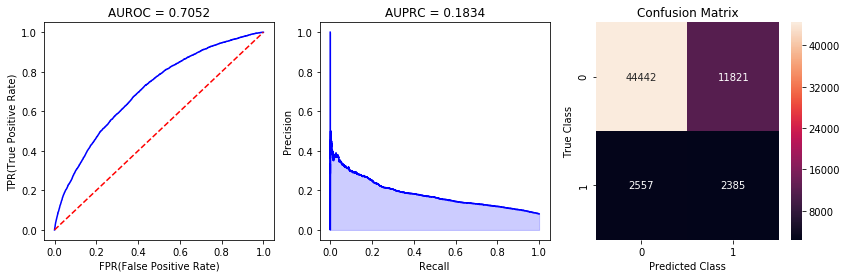

In [4]:
import xgboost as xgb
import joblib, pickle

val_data, val_y = joblib.load('trnval/valid.pkl')
dval = xgb.DMatrix(val_data.values)

model_xgb = pickle.load(open("xgboost-model-a", "rb"))
y_pred_xgb_a = model_xgb.predict(dval)
evaluate_prediction(val_y.values, y_pred_xgb_a)

In [5]:
%%sh

export TRAINING_JOB_NAME='xgboost-2019-08-16-01-49-33-608'
export MODEL_ARTIFACT=`aws sagemaker describe-training-job \
--training-job-name $TRAINING_JOB_NAME \
--query ModelArtifacts.S3ModelArtifacts \
--output text`

echo $MODEL_ARTIFACT

aws s3 cp $MODEL_ARTIFACT .
tar xvfz model.tar.gz
mv xgboost-model xgboost-model-b
rm model.tar.gz

s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-2019-08-16-01-49-33-608/output/model.tar.gz
download: s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-2019-08-16-01-49-33-608/output/model.tar.gz to ./model.tar.gz
xgboost-model


confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     56263
           1       0.17      0.54      0.26      4942

   micro avg       0.76      0.76      0.76     61205
   macro avg       0.56      0.66      0.56     61205
weighted avg       0.89      0.76      0.81     61205



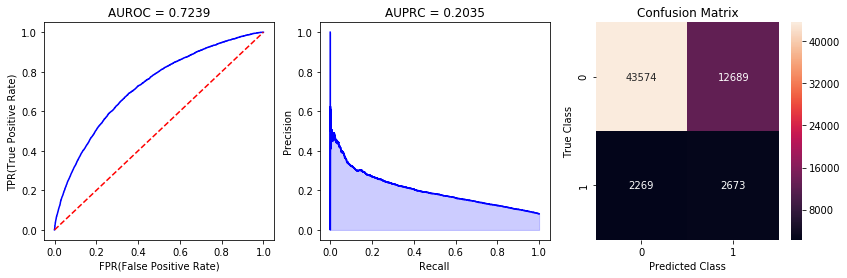

In [6]:
model_xgb = pickle.load(open("xgboost-model-b", "rb"))
y_pred_xgb_b = model_xgb.predict(dval)
evaluate_prediction(val_y.values, y_pred_xgb_b)

<br>

## 1. Create Models
----
- 기 학습된 Model Artifacts로부터 Depolyment를 위한 Model을 생성합니다.

In [7]:
info1 = sm.describe_training_job(TrainingJobName=training_job_name1)
model_data1 = info1['ModelArtifacts']['S3ModelArtifacts']

info2 = sm.describe_training_job(TrainingJobName=training_job_name2)
model_data2 = info2['ModelArtifacts']['S3ModelArtifacts']

print('model_path1: {}\nmodel_path2: {}'.format(model_data1, model_data2))

try:
    sm.delete_model(ModelName = model_name1)
    sm.delete_model(ModelName = model_name2)
except:
    print('Inference models do not exist.')

model_path1: s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-190815-0826-150-155b7ff1/output/model.tar.gz
model_path2: s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-2019-08-16-01-49-33-608/output/model.tar.gz
Inference models do not exist.


In [8]:
primary_container1 = {
    'Image': container,
    'ModelDataUrl': model_data1
}
primary_container2 = {
    'Image': container,
    'ModelDataUrl': model_data2
}

create_model_response1 = sm.create_model(
    ModelName = model_name1,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container1
)

create_model_response2 = sm.create_model(
    ModelName = model_name2,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container2
)

<br>

## 2. Create an Endpoint
----

### Create an Endpoint Configuration
- 여러 버전의 모델들을 한 Endpoint 내에서 배포하려면 Boto3 SDK에서 Endpoint configuration을 직접 수정해야 합니다. 
    - `sagemaker.create_endpoint_config()` 메서드의 `ProductionVariants` 인자값(dictionary형)을 수정합니다.
    - 처음에는 두 모델의 트래픽 비율을 1:1로 동일하게 맞추기 위해 `'InitialVariantWeight': 1`로 설정합니다.
    - Reference: https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/API_CreateEndpointConfig.html

In [9]:
from time import gmtime, strftime   
endpoint_config_name = 'ABTest-Config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'model-a',        
            'ModelName': model_name1,
            'InstanceType': 'ml.t2.medium',
            'InitialInstanceCount': 1,
            'InitialVariantWeight': 1
        },
        {
            'VariantName': 'model-b',        
            'ModelName': model_name2,
            'InstanceType': 'ml.t2.medium',
            'InitialInstanceCount': 1,
            'InitialVariantWeight': 1
        }        
    ],
    Tags=[
        {
            'Key': 'abtest-key',
            'Value': 'abtest-value'
        },
    ]
)

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

ABTest-Config-2019-08-20-06-30-37
Endpoint Config Arn: arn:aws:sagemaker:us-west-2:143656149352:endpoint-config/abtest-config-2019-08-20-06-30-37


### Create the Endpoint from the Endpoint Configuration 
- Endpoint를 생성합니다. Endpoint 생성은 약 10분 정도 소요됩니다.

In [10]:
%%time
import time

endpoint_name = 'ABTest-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)

create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)

print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status == 'Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

ABTest-2019-08-20-06-30-41
arn:aws:sagemaker:us-west-2:143656149352:endpoint/abtest-2019-08-20-06-30-41
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:143656149352:endpoint/abtest-2019-08-20-06-30-41
Status: InService
CPU times: user 112 ms, sys: 3.25 ms, total: 115 ms
Wall time: 9min 1s


<br>

## 3. Run an A/B Test
----

### Initial weights
- 처음에는 트래픽 1:1 비율에서 실시간 예측을 수행합니다.

In [8]:
# import joblib
# val_data, val_y = joblib.load('trnval/valid.pkl')

In [11]:
import numpy as np
from sagemaker.predictor import csv_serializer
#endpoint_name = 'ABTest-TrafficWeight-1-1-2019-08-20-05-44-45'

sess = sagemaker.Session()
abtest_predictor = sagemaker.RealTimePredictor(
    endpoint=endpoint_name,
    sagemaker_session=sess, 
    content_type = 'text/csv',
    serializer = csv_serializer
)

In [12]:
%%time
from evaluate_fn import predict_from_realtime_predictor
val_y_pred = predict_from_realtime_predictor(val_data.values, abtest_predictor)

CPU times: user 7.77 s, sys: 129 ms, total: 7.9 s
Wall time: 27.1 s


confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     56263
           1       0.17      0.51      0.26      4942

   micro avg       0.76      0.76      0.76     61205
   macro avg       0.56      0.65      0.56     61205
weighted avg       0.89      0.76      0.81     61205



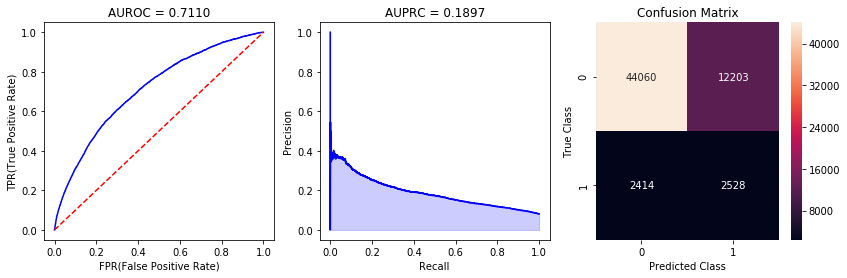

In [13]:
evaluate_prediction(val_y.values, val_y_pred)

- 위와 동일한 코드로 실시간 예측을 수행합니다.
- **1:1 비율로 트래픽이 두 개의 모델로 분산**되기 때문에 매번 clasification 예측 결과가 변하는 것을 확인할 수 있습니다.

In [14]:
%%time
val_y_pred = predict_from_realtime_predictor(val_data.values, abtest_predictor)

CPU times: user 7.79 s, sys: 115 ms, total: 7.91 s
Wall time: 25.5 s


confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     56263
           1       0.17      0.52      0.26      4942

   micro avg       0.76      0.76      0.76     61205
   macro avg       0.56      0.65      0.56     61205
weighted avg       0.89      0.76      0.81     61205



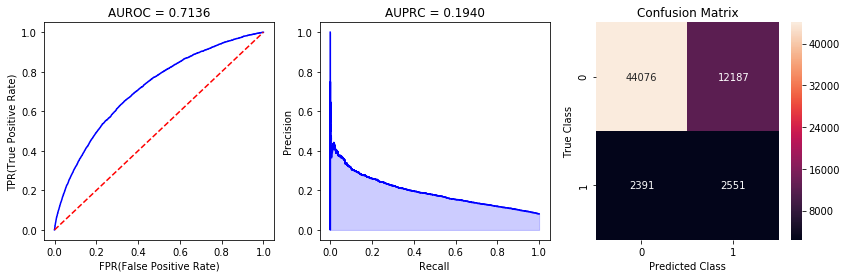

In [15]:
evaluate_prediction(val_y.values, val_y_pred)

### Update weights
- 이번에는 해당 Endpoint를 클릭 후 **Endpoint runtime settings**란의 **Update weights**를 클릭 후 Old Model과 New Model의 비율을 **1:1 대신 1:10으로 조절**합니다.
- 2-3분 경과 후에 아래의 코드를 수행하여 결과를 확인합니다.
- 전반적으로 New Model 쪽에 트래픽이 더 많이 분산되기 때문에 New 모델의 예측 성능에 좀 더 가깝다는 점을 확인할 수 있습니다.

In [16]:
%%time
val_y_pred = predict_from_realtime_predictor(val_data.values, abtest_predictor)

CPU times: user 7.9 s, sys: 144 ms, total: 8.05 s
Wall time: 25 s


confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.78      0.85     56263
           1       0.17      0.53      0.26      4942

   micro avg       0.76      0.76      0.76     61205
   macro avg       0.56      0.65      0.56     61205
weighted avg       0.89      0.76      0.81     61205



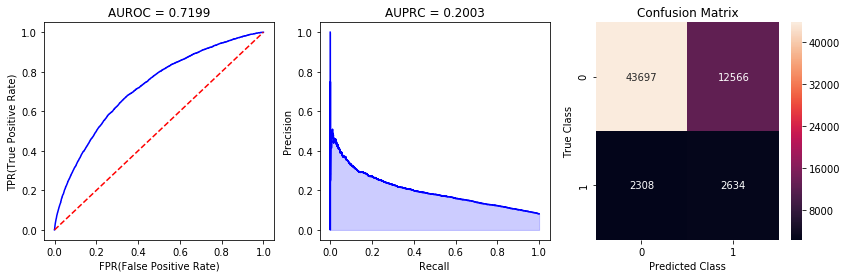

In [17]:
evaluate_prediction(val_y.values, val_y_pred)

In [18]:
%%time
val_y_pred = predict_from_realtime_predictor(val_data.values, abtest_predictor)

CPU times: user 8 s, sys: 137 ms, total: 8.13 s
Wall time: 25.3 s


confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.78      0.85     56263
           1       0.17      0.54      0.26      4942

   micro avg       0.76      0.76      0.76     61205
   macro avg       0.56      0.66      0.56     61205
weighted avg       0.89      0.76      0.81     61205



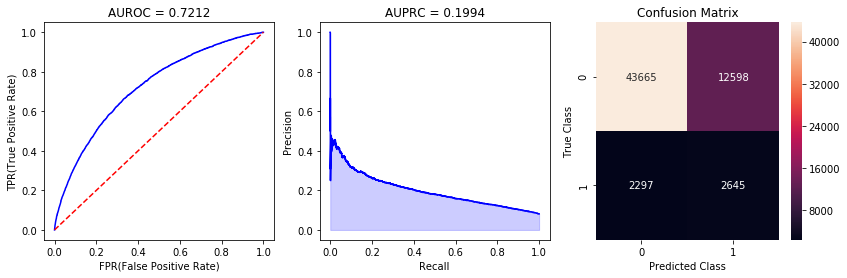

In [19]:
evaluate_prediction(val_y.values, val_y_pred)